In [ ]:
import praw
import json
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
with open("config.json", "r") as jsonfile:
    data = json.load(jsonfile)  # Reading the config file
#     print("Config data read successful", data)

In [ ]:
from collections import namedtuple  # Each element will be assigned a field
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession,SQLContext
# Allow us to order things in decscending order
from pyspark.sql.functions import desc
# create spark configuration
conf = SparkConf()
conf.setAppName("RedditStreamApp")
# create spark context with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# create the Streaming Context from the above spark context with interval size 10 seconds
ssc = StreamingContext(sc, 10)
# setting a checkpoint to allow RDD recovery
####ssc.checkpoint("checkpoint_RedditApp")
# read data from port 5590
# socket_stream = ssc.socketTextStream("localhost", 5590)
# sc = SparkContext() # Establish an entry point of Apache Spark functionality.
# ssc = StreamingContext(sc, 10) # Create streaming context with intervals of 10 seconds.
sqlContext = SQLContext(sc) # Initialising Spark SQL functionalities.
socket_stream = ssc.socketTextStream("127.0.0.1", 5590)

In [ ]:
### Modify the code here to match your logic in reddit_producer.py
lines = socket_stream.window(20)
fields = ("author",'date','time','words', 'subreddit','body')
RedditComment = namedtuple('RedditComment', fields)

In [ ]:
x_times = []
y_avgs = []
y_UK = []
y_US = []

In [ ]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

def test_content(string):
    print(string)
    return eval(string)

def get_average(x):
    total = sum(x)
    length = len(x)
    return int(sum(x) / len(x))

def make_plot(x, y):
    plt.plot(x, y)
    plt.xticks(rotation=45, ha='right')
    plt.title('Average number of unique words per comment every 10s')
    plt.show()

def make_double_plot(x, y1, y2):
    y1 = np.array(y1)
    y2 = np.array(y2)
    y1 = np.cumsum(y1)
    y2 = np.cumsum(y2)

    plt.plot(x, y1, label='UK', color='blue', marker='o')
    plt.plot(x, y2, label='US', color='green', linestyle='--', marker='s')
    plt.xticks(rotation=45, ha='right')

    plt.title('cumulative number of unique words in comments every 10 seconds for UK & US')
    plt.legend()

    plt.show()

def process_rdd(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        sql_context = get_sql_context_instance(rdd.context)
        row_rdd = rdd.map(lambda rec: RedditComment(rec['author'],rec['date'],rec['time'],rec['words'],rec['subreddit'],rec['body']))
        comments_df = sql_context.createDataFrame(row_rdd)
        comments_df.registerTempTable("comments")
        #comments_df_sql = sql_context.sql("select * from comments limit 5")
        #comments_df_sql.show()

        df = comments_df.toPandas()
        x_times.append(str(time).split(" ")[1])
        y_avgs.append(get_average(df['words']))
        
        #make_plot(x_times, y_avgs)

        uk_post = df[df['subreddit'] == "AskUK"]
        us_post = df[df['subreddit'] == "AskAnAmerican"]

        y_UK.append(sum(uk_post['words']))
        y_US.append(sum(us_post['words']))
        make_double_plot(x_times, y_UK, y_US)

        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)


(lines.map(lambda text: test_content(text)).foreachRDD(process_rdd))

In [ ]:
ssc.start()

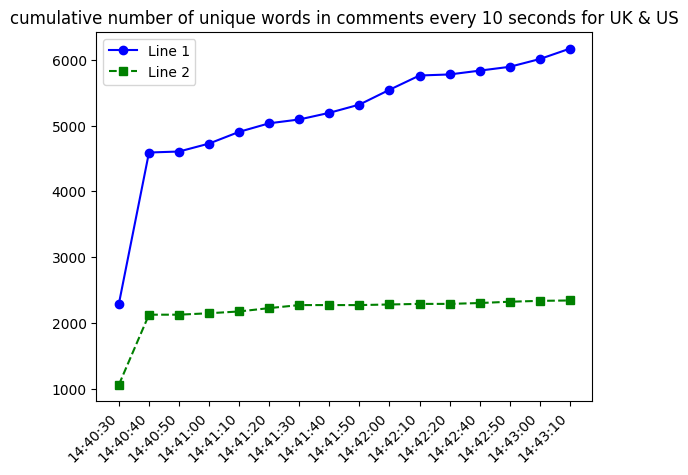

In [8]:
ssc.stop()